<h1>A. Data Collection & Exploration

In [2]:
import numpy as np, matplotlib as mpl, matplotlib.pyplot as plt, pandas as pd
import seaborn as sns
%matplotlib inline
import sklearn
import xgboost as xgb
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from mpl_toolkits import mplot3d
from sklearn.preprocessing import LabelEncoder
from pylift import TransformedOutcome
from pylift.generate_data import dgp

In [3]:
df_data = pd.read_csv('HR_comma_sep.csv')
df_data.index.name = "id"

In [1]:
df_data

NameError: name 'pd' is not defined

<h1>B. Data Preprocessing

In [44]:
#Checking columns that can be safely label encoded
object_cols = [col for col in df_data.columns if df_data[col].dtype == "object"]
good_label_cols = [col for col in object_cols if 
                   set(df_data[col]) == set(df_data[col])]
print('B.1. Columns that can be safely label encoded:\n>>{}'.format(good_label_cols))

#Checking uniques data in Department column
col_to_check1 = 'Department'
uniques = df_data[col_to_check1].unique()
print('\nB.2. All unique data in {} column:\n>>{}'.format(col_to_check1,uniques))

#Checking uniques data in Department column
col_to_check2 = 'salary'
uniques = df_data[col_to_check2].unique()
print('\nB.3. All unique data in {} column:\n>>{}'.format(col_to_check2,uniques))

B.1. Columns that can be safely label encoded:
>>['Department', 'salary']

B.2. All unique data in Department column:
>>['sales' 'accounting' 'hr' 'technical' 'support' 'management' 'IT'
 'product_mng' 'marketing' 'RandD']

B.3. All unique data in salary column:
>>['low' 'medium' 'high']


In [45]:
#Label encoding
label_encoder = LabelEncoder()
for col in good_label_cols:
    df_data[col] = label_encoder.fit_transform(df_data[col])
print("B.4. Label Encoding")
print(">>Label encoding for column {} is successful!".format(good_label_cols))
df_data

B.4. Label Encoding
>>Label encoding for column ['Department', 'salary'] is successful!


,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary
id,,,,,,,,,,
0,0.38,0.53,2,157,3,0,1,0,7,1
1,0.80,0.86,5,262,6,0,1,0,7,2
2,0.11,0.88,7,272,4,0,1,0,7,2
3,0.72,0.87,5,223,5,0,1,0,7,1
4,0.37,0.52,2,159,3,0,1,0,7,1
...,...,...,...,...,...,...,...,...,...,...
14994,0.40,0.57,2,151,3,0,1,0,8,1
14995,0.37,0.48,2,160,3,0,1,0,8,1
14996,0.37,0.53,2,143,3,0,1,0,8,1


B.5. Calculate total employee attrition
>>Total employee = 14,999 employees
>>Total employee left = 3,571 employees
>>Total employee stay = 11,428 employees
>>Total employee attrition = 23.81%


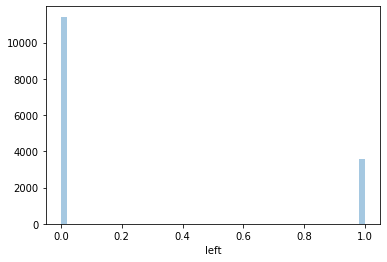

In [46]:
#Get total employee attrition
left_count = len(df_data[df_data.left == 1].index)
stay_count = len(df_data[df_data.left == 0].index)
total_count = left_count + stay_count
churn = (left_count/total_count)*100
print("""B.5. Calculate total employee attrition
>>Total employee = {:,} employees
>>Total employee left = {:,} employees
>>Total employee stay = {:,} employees""".format(total_count,left_count,stay_count))
print(">>Total employee attrition = {:.2f}%".format(churn))
sns.distplot(a=df_data.left, hist=True,kde=False)

B.6. Inverting data from column 'left':[1 1 1 1 1 1 1 1 1 1] ... 
Inverted result named 'stay':[0, 0, 0, 0, 0, 0, 0, 0, 0, 0] ... 
Column 'left' has been successfully replaced by new column 'stay'!


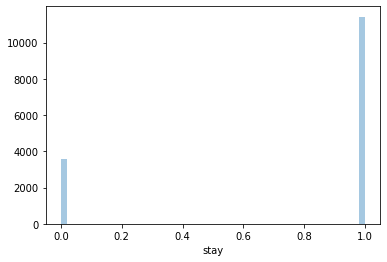

In [47]:
#setup the target column to be inverted and prepare empty array named inverted
input_data = df_data.left
inverted = []
print ("B.6. Inverting data from column '{}':{} ... ".format(input_data.name,df_data.left.values[:10]))

#inverting through all datas in column
for i in range(len(input_data)):
    inverted.append(1 - input_data[i])
print ("Inverted result named 'stay':{} ... ".format(inverted[:10]) )

#add new column stay and remove column left
df_data['stay']=inverted
df_data.drop(['left'], axis = 1)
print ("Column 'left' has been successfully replaced by new column 'stay'!")

#check the result
sns.distplot(a=df_data.stay, hist=True,kde=False)

B.7. Categorizing employees into: CN(0), CR(1), TN(2), and TR(3)
>>Categorizing successfull


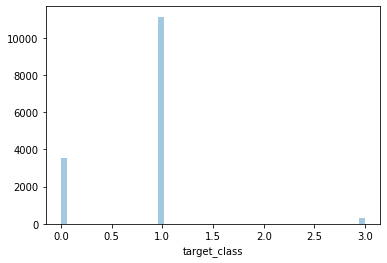

In [48]:
print("B.7. Categorizing employees into: CN(0), CR(1), TN(2), and TR(3)")
#to get the CN employees we can simply set the basic value of all data in column target_class equal to 0 
df_data['target_class'] = 0 #CN

#after that we set CR employees with target_class equal to 1 
df_data.loc[(df_data.promotion_last_5years == 0) & (df_data.stay > 0),'target_class'] = 1 #CR

#after that we set TN employees with with target_class equal to 2
df_data.loc[(df_data.promotion_last_5years == 1) & (df_data.stay == 0),'target_class'] = 2 #TN

#after that we set TR employees with with target_class equal to 3
df_data.loc[(df_data.promotion_last_5years == 1) & (df_data.stay > 0),'target_class'] = 3 #TR
print(">>Categorizing successfull")
sns.distplot(a=df_data.target_class, kde=False)

In [49]:
unique_elements, counts_elements = np.unique(df_data.target_class, return_counts=True)
print("Frequency of unique values of the said array:")
print(np.asarray((unique_elements, counts_elements)))

Frequency of unique values of the said array:
[[    0     1     2     3]
 [ 3552 11128    19   300]]


<h1>C.I. Manual Uplift Modelling

In [50]:
#create feature set and labels
X = df_data.drop(['stay'],axis=1)
y = df_data.target_class

#splitting train and test groups
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#fitting the model and predicting the probabilities using eXtreme Gradient Boosting
xgb_model = xgb.XGBClassifier().fit(X_train, y_train) 

#Calculate probabilities for all customers using eXtreme Gradient Boost
overall_proba = xgb_model.predict_proba(df_data.drop(['stay'],axis=1))

#assign probabilities to 4 different columns
df_data['CN'] = overall_proba[:,0] 
df_data['CR'] = overall_proba[:,1] 
df_data['TN'] = overall_proba[:,2] 
df_data['TR'] = overall_proba[:,3]
# df_data['target_predict'] = overall_proba
PC = len(df_data.loc[(df_data.promotion_last_5years == 0)])
PT = len(df_data.loc[(df_data.promotion_last_5years == 1)])
                     

# #set benefit
# b=200
# #set promotion
# p=50
# #set revenue
# r1=b-p
# r2=-p
                     
# calculate uplift score for all customers
# df_data['MP'] = df_data.eval('(CN+TR)*150 + (CN+TN)*0 + ((CR+TR)*-50) + ((CR+TN)*-50)')

# assign it back to main dataframe
# df_data['MP'] = df_data['MP']

In [51]:
# unique_elements, counts_elements = np.unique(df_data.target_predict, return_counts=True)
# print("Frequency of unique values of the said array:")
# print(np.asarray((unique_elements, counts_elements)))

In [52]:
# import sys
# np.set_printoptions(threshold=sys.maxsize)
# label=["1","2","3","4","5","6","7","8","9"]
# df_data['decile'] = pd.qcut(df_data['MP'],10,precision=0,labels=False, duplicates='drop')
# df_data['decile'].values

In [53]:
# pd.options.display.max_rows = 999
# print(sum(df_data.CN))
# print(sum(df_data.CR))
# print(sum(df_data.TN))
# print(sum(df_data.TR))

In [54]:
# plt.figure(figsize=(20,10))
# sns.distplot(a=df_data.target_predict, kde=False)

In [55]:
# plt.figure(figsize=(15,8))
# sns.barplot(data=df_data, x=df_data.index, y='MP')

In [83]:
df_data

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary,stay,target_class,CN,CR,TN,TR,TransformedOutcome
id,,,,,,,,,,,,,,,,,
0,0.38,0.53,2,157,3,0,1,0,7,1,0,0,0.999812,0.000097,0.000049,0.000042,-0
1,0.80,0.86,5,262,6,0,1,0,7,2,0,0,0.999788,0.000121,0.000049,0.000042,-0
2,0.11,0.88,7,272,4,0,1,0,7,2,0,0,0.999812,0.000097,0.000049,0.000042,-0
3,0.72,0.87,5,223,5,0,1,0,7,1,0,0,0.999788,0.000121,0.000049,0.000042,-0
4,0.37,0.52,2,159,3,0,1,0,7,1,0,0,0.999812,0.000097,0.000049,0.000042,-0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14994,0.40,0.57,2,151,3,0,1,0,8,1,0,0,0.999812,0.000097,0.000049,0.000042,-0
14995,0.37,0.48,2,160,3,0,1,0,8,1,0,0,0.999812,0.000097,0.000049,0.000042,-0
14996,0.37,0.53,2,143,3,0,1,0,8,1,0,0,0.999812,0.000097,0.000049,0.000042,-0


<h1>C.II. Pylift Uplift Modelling

In [56]:
# Specify your dataframe, treatment column, and outcome column.
up = TransformedOutcome(df_data, col_treatment='promotion_last_5years', col_outcome='stay')
print("""C.II.1. Instantiation
>>Instantiation complete

NOTE: The instantiation step accomplishes several things:
1. Define the transform function and transform the outcome 
   (this is added to the dataframe you pass in, by default, as a new column, TransformedOutcome).
2. Split the data using train_test_split.
3. Set a random state (we like determinism!). This random state is used wherever possible.
4. Define an untransform function and use this to define a scoring function for hyperparameter tuning. 
   The scoring function is saved within up.randomized_search_params and up.grid_search_params, which are dictionaries that are used by default whenever up.randomized_search() or up.grid_search() are called.
5. Define some default hyperparameters.""")


C.II.1. Instantiation
>>Instantiation complete

NOTE: The instantiation step accomplishes several things:
1. Define the transform function and transform the outcome 
   (this is added to the dataframe you pass in, by default, as a new column, TransformedOutcome).
2. Split the data using train_test_split.
3. Set a random state (we like determinism!). This random state is used wherever possible.
4. Define an untransform function and use this to define a scoring function for hyperparameter tuning. 
   The scoring function is saved within up.randomized_search_params and up.grid_search_params, which are dictionaries that are used by default whenever up.randomized_search() or up.grid_search() are called.
5. Define some default hyperparameters.


C.II.2. Finding the best N_estimators
Testing n_estimators in range 1-500 increment = 10 ...
[22:26:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:26:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:26:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:26:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:26:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:26:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:26:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:26:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor 

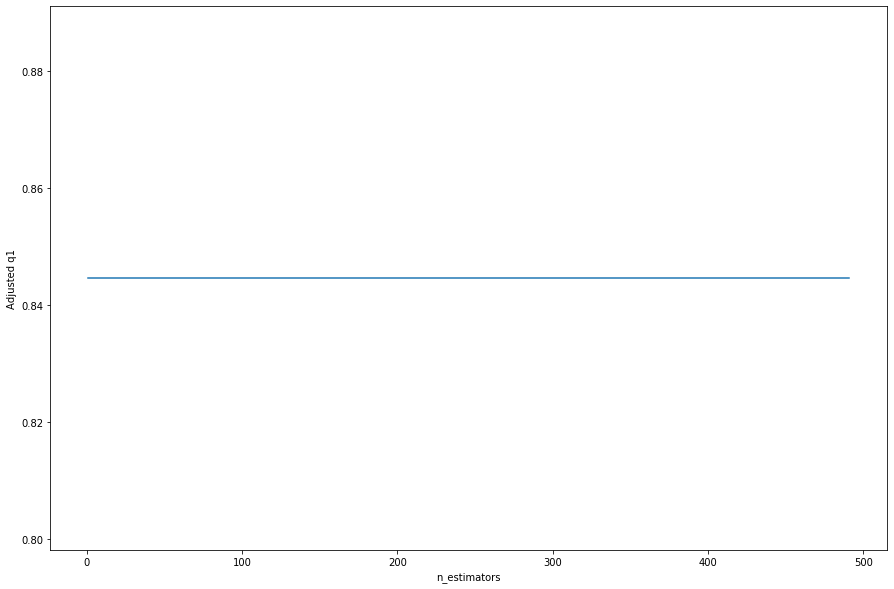

In [57]:
#finding the best n_estimators
print("C.II.2. Finding the best N_estimators")
print("Testing n_estimators in range 1-500 increment = 10 ...")
ranges = list(range(1,500,10))
scores = []

for val in ranges:
    up.fit(n_estimators=val, nthread=2)
    scores.append(up.test_results_.q1_aqini)
best_n = ranges[scores.index(max(scores))]
print("Testing successfull!")
plt.figure(figsize=(15,10))
plt.plot(ranges, scores)
plt.xlabel('n_estimators')
plt.ylabel('Adjusted q1')
print("Best n_estimators =",best_n)

[22:27:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
C.II.3. Fitting
>>fitting successful


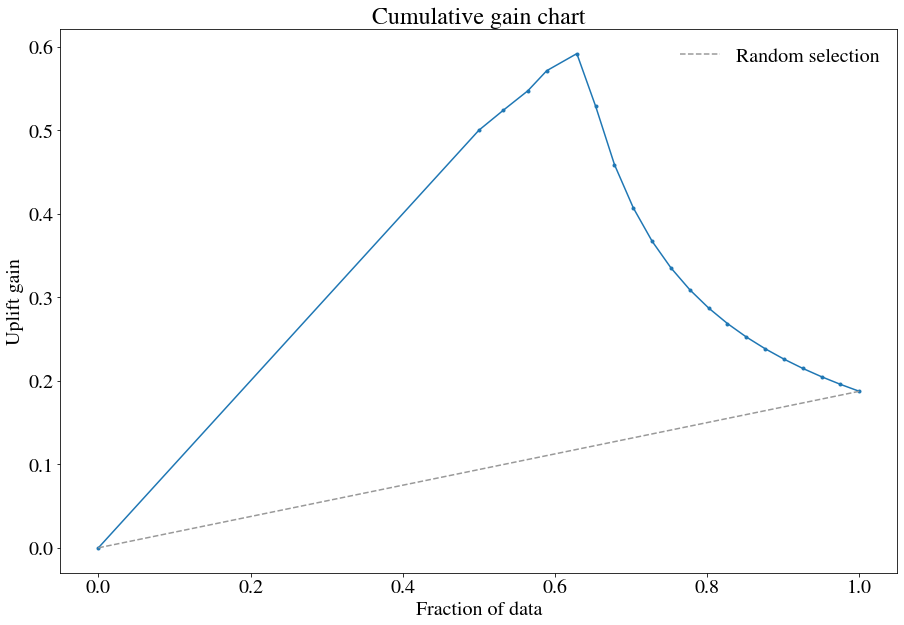

In [58]:
up.fit(n_estimators=best_n, random_state=42)
print("C.II.3. Fitting\n>>fitting successful")
up.plot()

No handles with labels found to put in legend.


C.II.4. Calculating Cumulative Uplift Curve


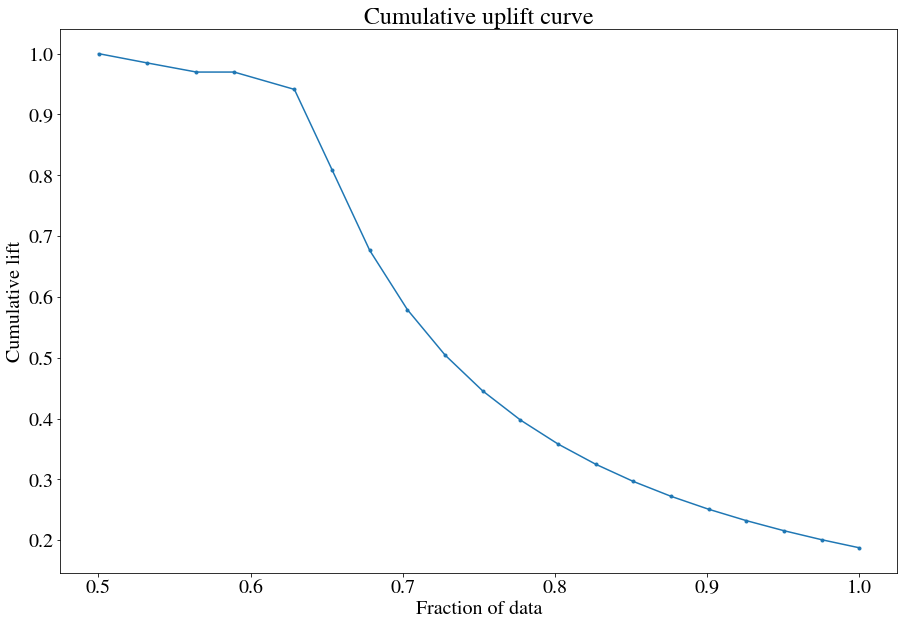

In [59]:
print("C.II.4. Calculating Cumulative Uplift Curve")
up.plot(plot_type='cuplift')

<h1>D. Evaluate Model

No handles with labels found to put in legend.


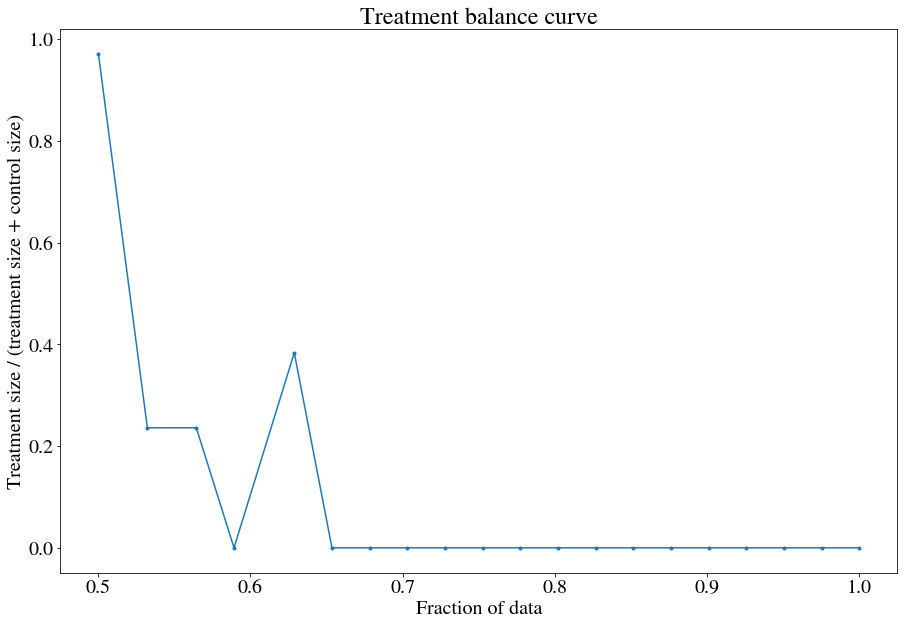

In [60]:
up.plot(plot_type='balance')

Treatment Balance: ratio of treatment group size to total group size within each bin

D.1.a. Calculating Qini Curve


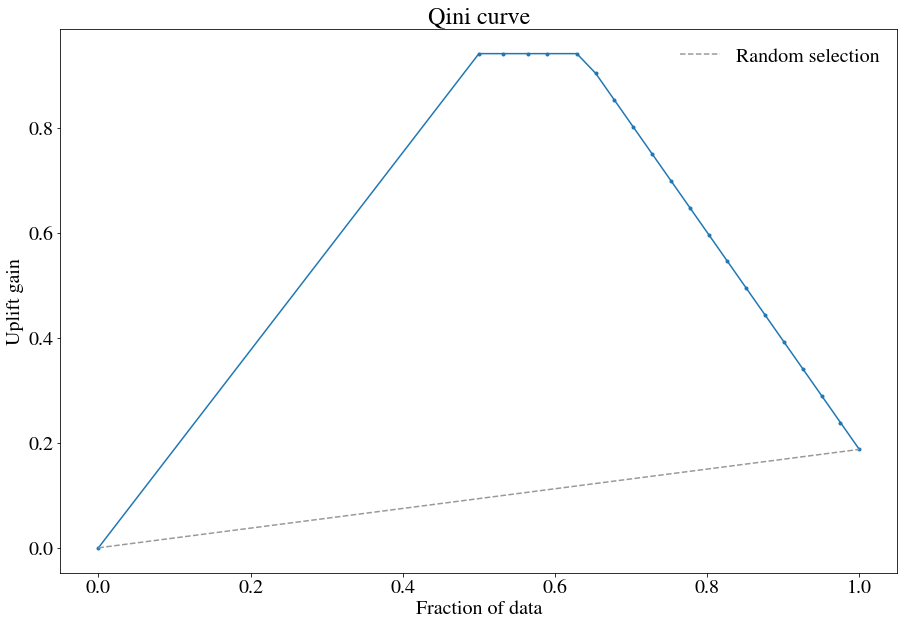

In [61]:
print("D.1.a. Calculating Qini Curve")
up.plot(plot_type='qini')

typical Qini curve (see Radcliffe 2007), normalized by the total number of people in treatment. 

In [62]:
print("D.1.b. Qini Result = {:.2f}%".format(up.test_results_.q1_qini*100))

D.1.b. Qini Result = 108.10%


In [63]:
# Error below:
# up.shuffle_fit()
# up.plot(plot_type='qini', show_shuffle_fits=True)

D.2.a. Calculating Adjusted Qini Curve


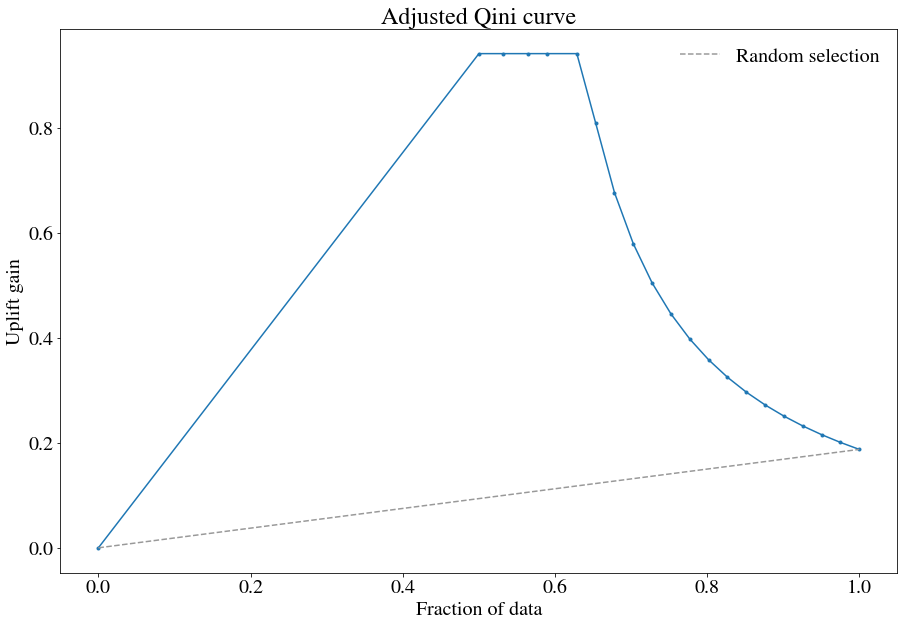

In [64]:
print("D.2.a. Calculating Adjusted Qini Curve")
up.plot(plot_type='aqini')

In [65]:
# Error below:
# up.shuffle_fit()
# up.plot(plot_type='aqini', show_shuffle_fits=True)

In [66]:
print("D.2.b. Adjusted Qini Result = {:.2f}%".format(up.test_results_.q1_qini*100))

D.2.b. Adjusted Qini Result = 108.10%


<h1>Other experiments:

<h2>E. Implementing Random Search

In [67]:
up.randomized_search(n_iter=20, n_jobs=10, random_state=1)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:   30.6s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:  3.2min finished


RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1, gamma=0,
                                          importance_type='gain',
                                          learning_rate=0.1, max_delta_step=0,
                                          max_depth=3, min_child_weight=1,
                                          missing=None, n_estimators=100,
                                          n_jobs=1, nthread=1,
                                          objective='reg:linear',
                                          random_state=0, reg_alpha=...
                                                      16, 17, 18, 19, 20],
                                        'min_child_weight': [1, 2, 3, 4, 5, 6,
                                  

In [68]:
up.fit(**up.rand_search_.best_params_)

[22:30:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


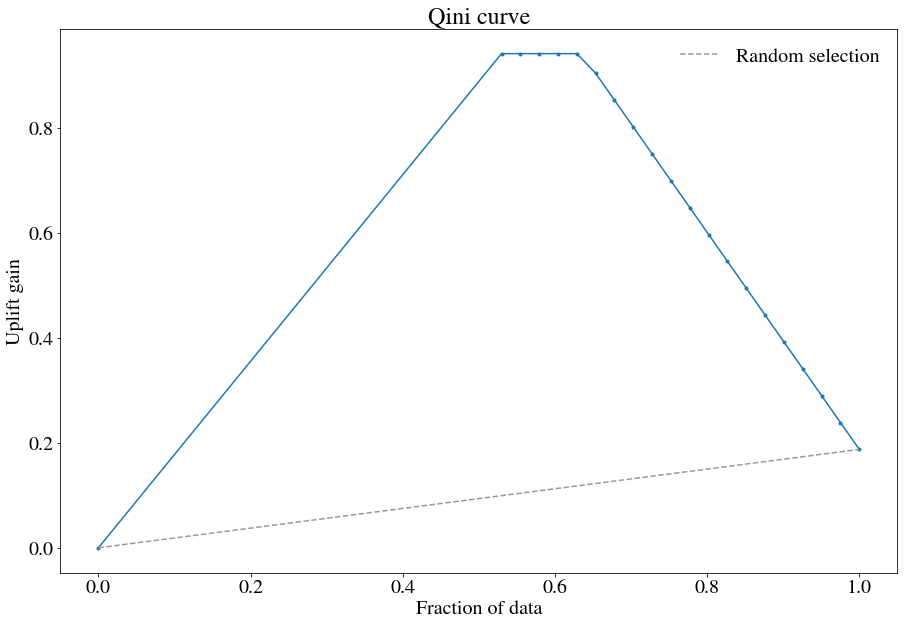

In [69]:
up.plot(plot_type='qini')

In [70]:
print("E.1.a. Qini Result = {:.2f}%".format(up.test_results_.q1_qini*100))

E.1.a. Qini Result = 108.10%


In [71]:
up.shuffle_fit(params=up.rand_search_.best_params_, nthread=30, iterations=5);

[22:30:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Seed 0 finished.
[22:30:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Seed 1 finished.
[22:30:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Seed 2 finished.
[22:30:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Seed 3 finished.
[22:30:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Seed 4 finished.


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


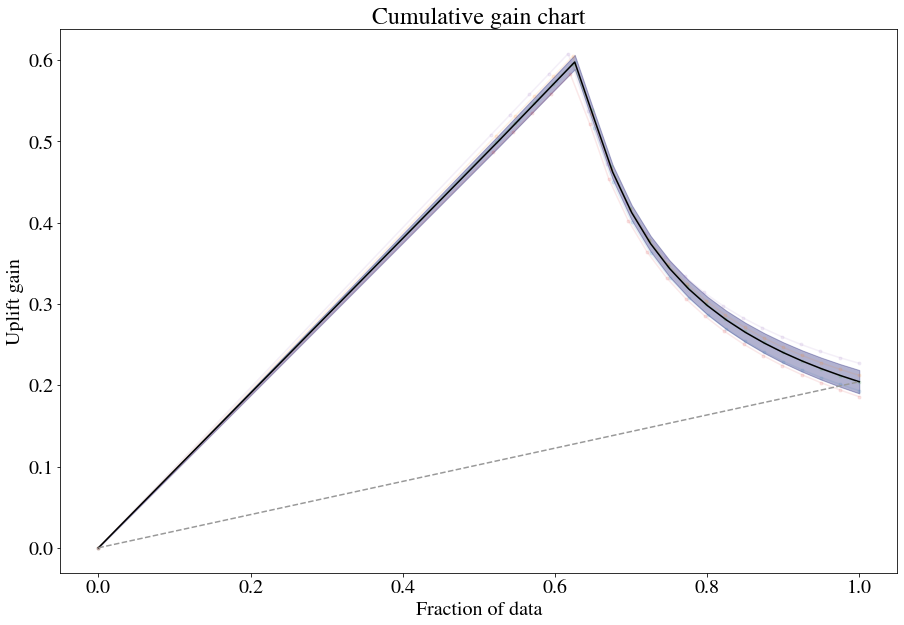

In [72]:
up.plot(show_shuffle_fits=True)

In [73]:
print("E.1.b. Cumulative Gain Result = {:.2f}%".format(up.test_results_.q1_cgains*100))

E.1.b. Cumulative Gain Result = 51.64%


In [74]:
up.noise_fit()

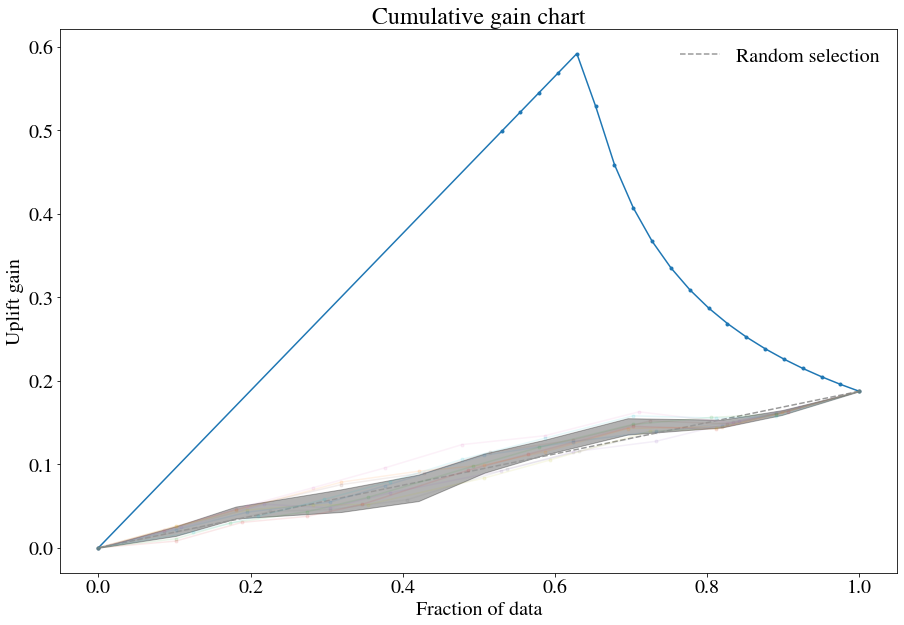

In [75]:
up.plot(show_noise_fits=True)

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


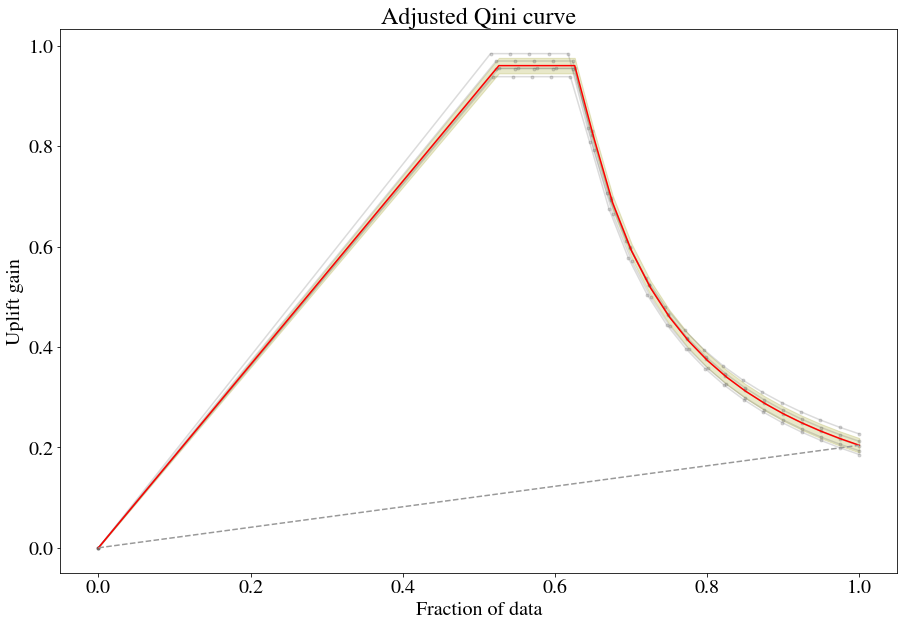

In [76]:
up.plot(plot_type='aqini',
        show_shuffle_fits=True,
        show_random_selection=True,
        shuffle_band_kwargs={'color':[0.7,0.7,0.3], 'alpha':0.3},
        shuffle_lines_kwargs={'color':[0.3,0.3,0.3], 'alpha':0.2},
        shuffle_avg_line_kwargs={'color':[1,0,0]}
       )

In [77]:
print("E.1.c. Adjusted Qini Result = {:.2f}%".format(up.test_results_.q1_aqini*100))

E.1.c. Adjusted Qini Result = 84.46%


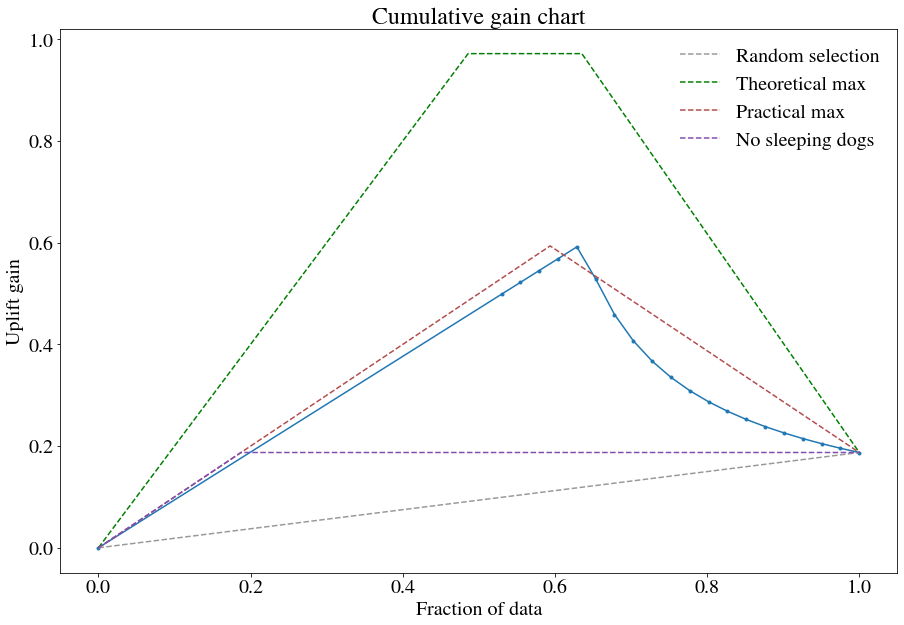

In [78]:
up.plot(show_theoretical_max=True, show_practical_max=True, show_no_dogs=True)

No handles with labels found to put in legend.


C.3. Calculating Cumulative Uplift Curve


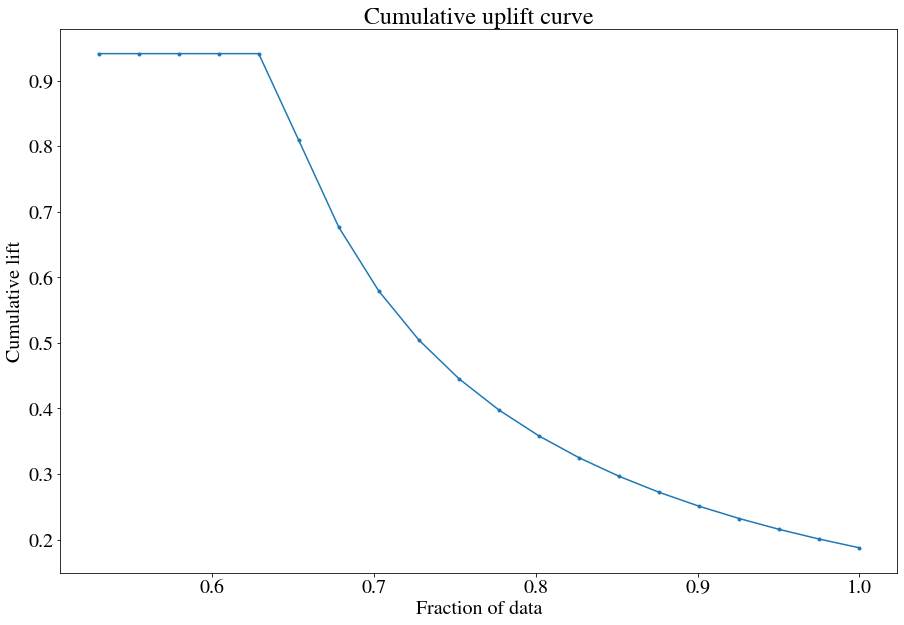

In [79]:
print("C.3. Calculating Cumulative Uplift Curve")
up.plot(plot_type='cuplift')

<h2>Independent use of evaluation metrics

here we can do customization

In [80]:
up.transformed_y_test_pred

array([-1.0122715, -1.0122715, 46.905132 , ..., 46.905132 , -1.0122715,
       -1.0122715], dtype=float32)

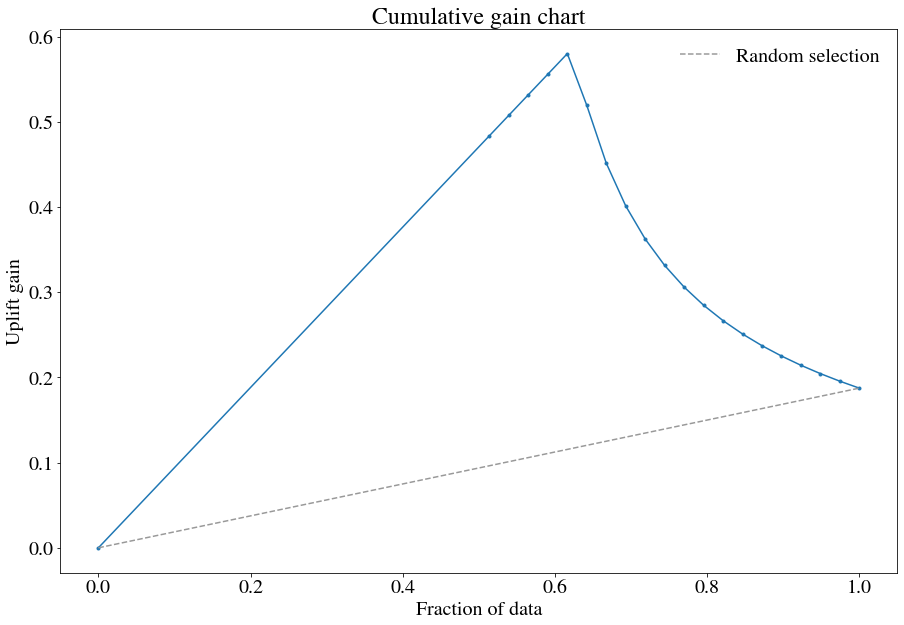

In [81]:
from pylift.eval import UpliftEval
upev = UpliftEval(up.tc_test, up.y_test, up.transformed_y_test_pred)
upev.plot()

In [82]:
# import sys
# np.set_printoptions(threshold=sys.maxsize)
df_data

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary,stay,target_class,CN,CR,TN,TR,TransformedOutcome
id,,,,,,,,,,,,,,,,,
0,0.38,0.53,2,157,3,0,1,0,7,1,0,0,0.999812,0.000097,0.000049,0.000042,-0
1,0.80,0.86,5,262,6,0,1,0,7,2,0,0,0.999788,0.000121,0.000049,0.000042,-0
2,0.11,0.88,7,272,4,0,1,0,7,2,0,0,0.999812,0.000097,0.000049,0.000042,-0
3,0.72,0.87,5,223,5,0,1,0,7,1,0,0,0.999788,0.000121,0.000049,0.000042,-0
4,0.37,0.52,2,159,3,0,1,0,7,1,0,0,0.999812,0.000097,0.000049,0.000042,-0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14994,0.40,0.57,2,151,3,0,1,0,8,1,0,0,0.999812,0.000097,0.000049,0.000042,-0
14995,0.37,0.48,2,160,3,0,1,0,8,1,0,0,0.999812,0.000097,0.000049,0.000042,-0
14996,0.37,0.53,2,143,3,0,1,0,8,1,0,0,0.999812,0.000097,0.000049,0.000042,-0
